## Basic Co-Training Implementation
**Based on the Blum and Mitchell, 1998 paper**

In [ ]:
import numpy as np
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import math
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB



In [2]:
#setA = ['rec.sport.baseball', 'rec.sport.hockey']
setA = ['comp.os.ms-windows.misc','comp.sys.ibm.pc.hardware']
setB = ['talk.politics.misc','talk.politics.guns']

newsA_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), categories=setA)
newsB_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), categories=setB)

newsA_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), categories=setA)
newsB_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), categories=setB)

newsA_y_train = newsA_train.target
newsB_y_train = newsB_train.target

newsA_y_test = newsA_test.target
newsB_y_test = newsB_test.target

vectorizerA = TfidfVectorizer()
newsA_X_train = vectorizerA.fit_transform(newsA_train.data)
newsA_X_test = vectorizerA.transform(newsA_test.data)

vectorizerB = TfidfVectorizer()
newsB_X_train = vectorizerB.fit_transform(newsB_train.data)
newsB_X_test = vectorizerB.transform(newsB_test.data)


In [4]:
print(newsA_y_train.shape)
print(newsA_X_train.shape)
print(newsB_y_train.shape)
print(newsB_X_train.shape)

print(newsA_X_test.shape)
print(newsA_y_test.shape)
print(newsB_X_test.shape)
print(newsB_y_test.shape)

(1181,)
(1181, 39223)
(1011,)
(1011, 19825)
(786, 39223)
(786,)
(674, 19825)
(674,)


In [5]:
#print(np.argsort(newsA_y_train))
orderA = np.argsort(newsA_y_train)
newsA_X_train = newsA_X_train[orderA]
newsA_y_train = newsA_y_train[orderA]
print(newsA_y_train.shape)

orderB = np.argsort(newsB_y_train)
newsB_X_train = newsB_X_train[orderB]
newsB_y_train = newsB_y_train[orderB]
print(newsB_y_train.shape)

# cut off the extras so both views same size
newsA_X_train = newsA_X_train[:min(len(newsA_y_train),len(newsB_y_train))]
newsA_y_train = newsA_y_train[:min(len(newsA_y_train),len(newsB_y_train))]

print(newsA_y_train.shape)



(1181,)
(1011,)
(1011,)


In [6]:
print((newsA_train.keys()))

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR', 'description'])


In [8]:
# split into labeled and unlabeled
Lsize = 12

np.random.seed(8)
mask = np.random.choice([False, True], (newsA_X_train.shape[0]), p=[((newsA_X_train.shape[0]) - Lsize)/(newsA_X_train.shape[0]), Lsize/(newsA_X_train.shape[0])])


newsA_X_train_L = newsA_X_train[mask,:]
newsA_y_train_L = newsA_y_train[mask]
newsA_X_train_U = newsA_X_train[mask==False,:]

newsB_X_train_L = newsB_X_train[mask,:]
newsB_y_train_L = newsB_y_train[mask]
newsB_X_train_U = newsB_X_train[mask==False,:]

print(newsA_y_train_L)
print(newsA_X_train_L.shape)
print(newsA_X_train_U.shape)



[0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]
(16, 39223)
(995, 39223)


In [160]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
import numpy as np
import random
class MVCoTrain:
    
    def __init__(self, model_type="Naive_Bayes"):
        if model_type == "Naive_Bayes":
            self.h1 = GaussianNB()
            self.h2 = GaussianNB()
        else:
            raise Exception("Bad model_type")
        self.model_type = model_type
        
    # return the most confident row indices for positive and negative
    def pred_self(self, modelnum, Z_X_UU, n, p):
        if modelnum=="h1":
            probs = self.h1.predict_proba(Z_X_UU)
            y_pred = self.h1.predict(Z_X_UU)
        elif modelnum=="h2":
            probs = self.h2.predict_proba(Z_X_UU)
            y_pred = self.h2.predict(Z_X_UU)
                    
        probs_class0 = probs[:,0]
        probs_class1 = probs[:,1]
        topN_class0 = np.argsort(probs_class0)[-n:]
        print("bad labels")
        print(y_pred[topN_class0]==1)
        print(topN_class0)
        topN_class0 = np.delete(topN_class0, y_pred[topN_class0]==1)
        print("after delete")
        print(topN_class0)
        topN_pred0 = y_pred[topN_class0]
#         print(" hhhh ")
#         print(y_pred)
#         print(probs)
        
#         print("here")
#         print(probs_class0[topN_class0])
#         print(topN_pred0)
        topP_class1 = np.argsort(probs_class1)[-p:]
        print("bad labels P")
        print(y_pred[topP_class1]==0)
        print("BEFORE DELETE")
        print(topP_class1)
        topP_class1 = np.delete(topP_class1, y_pred[topP_class1]==0)
        print("aFTER DELETE")
        print(topP_class1)
        topP_pred1 = y_pred[topP_class1]
        print([topN_class0])
        print([topP_class1])
#         print(probs_class1[topP_class1])
#         print(topP_pred1)
        best_locs = np.transpose(np.hstack([topN_class0, topP_class1]))
        preds = np.transpose(np.hstack([topN_pred0, topP_pred1]))
        if len(set(best_locs)) is not len(best_locs):
            print("Error")
            raise Exception
#         print(best_locs)
#         print(preds)
        return (best_locs, preds)

    # replenish UU subset with examples from U set
    def replenish(self, A_X_UU, A_X_U, B_X_UU, B_X_U, num_removed):
        # not enough examples left to fully replenish and have leftover
        if num_removed >= len(A_X_U):
            A_X_UU = np.vstack((A_X_UU, A_X_U))
            B_X_UU = np.vstack((B_X_UU, B_X_U))
            return (A_X_UU, np.array([]), B_X_UU, np.array([]))
        
        # choose a random sample of the examples in the unlabeled set U
        # to put into the UU subset
        random.seed(11)
        selector = np.arange(0,len(A_X_U))
        random.shuffle(selector)
        selector = selector[:num_removed]
        print(selector)
        A_X_UU = np.vstack((A_X_UU, A_X_U[selector,:]))
        B_X_UU = np.vstack((B_X_UU, B_X_U[selector,:]))
        # delete these from the unlabeled set U
        A_X_U = np.delete(A_X_U, selector, axis=0)
        B_X_U = np.delete(B_X_U, selector, axis=0)
        return (A_X_UU, A_X_U, B_X_UU, B_X_U)
        
        
    
    
    def fit_full(self, A_X_L, A_y_L, B_X_L, B_y_L, A_X_U, B_X_U, n=10, p=10, max_iters=20, seed=10):
        # randomly get subgroup of the unlabeled data
        UUsize = 4 * n + 4 * p
        np.random.seed(seed)
        mask = np.random.choice([False, True], (A_X_U.shape[0]), p=[((A_X_U.shape[0]) - UUsize)/(A_X_U.shape[0]), UUsize/(A_X_U.shape[0])])
        notMask = np.invert(mask)
#         print(notMask[:100])
#         print(mask[:100])
        notMask = np.flatnonzero(notMask)
        mask = np.flatnonzero(mask)
#         print(mask)
#         print(len(mask))
#         print(len(notMask))
#         print(A_X_U.shape)
        A_X_UU = A_X_U[mask,:]
        B_X_UU = B_X_U[mask,:]
        A_X_U = A_X_U[notMask,:]
        B_X_U = B_X_U[notMask,:]
#         print(A_X_U.shape)
#         print(A_X_UU.shape)
        
        
        A_X_L = A_X_L.toarray()
        B_X_L = B_X_L.toarray()
        A_X_U = A_X_U.toarray()
        B_X_U = B_X_U.toarray()
        A_X_UU = A_X_UU.toarray()
        B_X_UU = B_X_UU.toarray()
           
        # iterate and fit
        for n_iter in range(2):
            print("iter " + str(n_iter))
            # fit h1 on the labeled data A_X_L
            self.h1.fit(A_X_L, A_y_L)
            
            # fit h2 on labeled data B_X_L
            self.h2.fit(B_X_L, B_y_L)
            
            # get h1 predictions of A_X_UU
            best_rows1, best_preds1 = self.pred_self("h1", A_X_UU, n, p)
            print(best_rows1.shape)
                    
            # get the h2 predictions of B_X_UU
            best_rows2, best_preds2 = self.pred_self("h2", B_X_UU, n, p)
            print(best_rows2.shape)
            
            # union these and put these best predictions into B_X_L, then replenish both UU
            best_rows = np.array(list(set(np.hstack([best_rows1, best_rows2]))))
            print(best_rows.shape)
            num_removed = len(best_rows)
            
            y_L_new = np.zeros_like(best_rows)
            remove_mask = np.zeros_like(best_rows)
            for i,row in enumerate(best_rows):
                remove_mask[i] = row
                if row in best_rows1:
                    print("best row")
                    print(row)
                    print(best_rows1)
                    print(np.where(best_rows1==row))
                    y_L_new[i] = best_preds1[np.where(best_rows1==row)]
                else:
                    y_L_new[i] = best_preds2[np.where(best_rows2==row)]
                    
            
            print(y_L_new)
            
            # add to labeled sets
            print(A_X_L.shape)
            print(A_X_UU[best_rows,:].shape)
            
            A_X_L = np.vstack((A_X_L, A_X_UU[best_rows,:]))
            print(A_X_L.shape)
            B_X_L = np.vstack((B_X_L, B_X_UU[best_rows,:]))
            
            # Add labels########################
#             print("size")
#             print(y_L_new.shape)
#             print(A_y_L.shape)
#             print(B_y_L.shape)
            A_y_L = np.transpose(np.hstack((A_y_L, y_L_new)))
            B_y_L = np.transpose(np.hstack((B_y_L, y_L_new)))
#             print(A_y_L.shape)
#             print(B_y_L.shape)
            
            # remove from unlabeled set
            mask = np.ones((A_X_UU.shape[0],))
            mask[remove_mask] = 0
            print("UU shape")
            print(A_X_UU.shape)
            print(B_X_UU.shape)
            A_X_UU = A_X_UU[mask==1,:]
            B_X_UU = B_X_UU[mask==1,:]
            print(A_X_UU.shape)
            print(B_X_UU.shape)
            
            # replenish UU sets
            print("num removed")
            print(num_removed)
            print("before replenish")
            print(A_X_U.shape)
            print(A_X_UU.shape)
            (A_X_UU, A_X_U, B_X_UU, B_X_U) = self.replenish(A_X_UU, A_X_U, B_X_UU, B_X_U, num_removed)
            print("shape after replenish")
            print(A_X_U.shape)
            print(A_X_UU.shape)
            
            print("new shapes")
            print(A_X_L.shape)
            print(A_y_L.shape)
            print(B_X_L.shape)
            print(B_y_L.shape)
            
            
            
        
        
        

In [161]:
x = np.array([1,2,2,3,4,5,5,5,5,5,6])
y = np.array(list(set(x)))
print(y)

[1 2 3 4 5 6]


In [162]:
MVtest1 = MVCoTrain()
MVtest1.fit_full(newsA_X_train_L, newsA_y_train_L, newsB_X_train_L, newsB_y_train_L, newsA_X_train_U, newsB_X_train_U)

iter 0
bad labels
[False False False False False False False False False False]
[30  5 20 28 27 44 45 12 29 17]
after delete
[ 5 20 28 27 44 45 12 29 17]
bad labels P
[False False False False False False False False False False]
BEFORE DELETE
[26 31 33 34 35 71 37 38 19 72]
aFTER DELETE
[31 33 34 35 71 37 38 19 72]
[array([ 5, 20, 28, 27, 44, 45, 12, 29, 17], dtype=int64)]
[array([31, 33, 34, 35, 71, 37, 38, 19, 72], dtype=int64)]
(18,)


C:\Users\gavin\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: in the future insert will treat boolean arrays and array-likes as boolean index instead of casting it to integer
C:\Users\gavin\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: FutureWarning: in the future insert will treat boolean arrays and array-likes as boolean index instead of casting it to integer


bad labels
[False False False False False False False False False False]
[17 20 22 27 31 32 38 45 53 72]
after delete
[20 22 27 31 32 38 45 53 72]
bad labels P
[False False False False False False False False False False]
BEFORE DELETE
[35 71 37 39 40 41 42 43  8 36]
aFTER DELETE
[71 37 39 40 41 42 43  8 36]
[array([20, 22, 27, 31, 32, 38, 45, 53, 72], dtype=int64)]
[array([71, 37, 39, 40, 41, 42, 43,  8, 36], dtype=int64)]
(18,)
(28,)
best row
5
[ 5 20 28 27 44 45 12 29 17 31 33 34 35 71 37 38 19 72]
(array([0], dtype=int64),)
best row
12
[ 5 20 28 27 44 45 12 29 17 31 33 34 35 71 37 38 19 72]
(array([6], dtype=int64),)
best row
17
[ 5 20 28 27 44 45 12 29 17 31 33 34 35 71 37 38 19 72]
(array([8], dtype=int64),)
best row
19
[ 5 20 28 27 44 45 12 29 17 31 33 34 35 71 37 38 19 72]
(array([16], dtype=int64),)
best row
20
[ 5 20 28 27 44 45 12 29 17 31 33 34 35 71 37 38 19 72]
(array([1], dtype=int64),)
best row
27
[ 5 20 28 27 44 45 12 29 17 31 33 34 35 71 37 38 19 72]
(array([3], dtype

Exception: 

### from https://github.com/jjrob13/sklearn_cotraining/blob/master/sklearn_cotraining/classifiers.py

In [ ]:
import numpy as np
import random
import copy
class CoTrainingClassifier(object):
    """
    Organization from https://github.com/jjrob13/sklearn_cotraining
    Algorithm based on "Combining Labeled and Unlabeled Data with Co-Training", Blum and Mitchell, 1998 
    
    Parameters:
    clf - The classifier that will be used in the cotraining algorithm on the view 1 feature set
        (If clf2 is not specified, then the same type of classifier will be used on the second view).

    clf2 - (Optional) A different classifier type can be specified to be used on the X2 feature set
         if desired.

    p - (Optional) The number of positive examples that will be 'labeled' by each classifier during each iteration
        The default is the is determined by the smallest integer ratio of positive to negative samples in L (from paper)

    n - (Optional) The number of negative examples that will be 'labeled' by each classifier during each iteration
    The default is the is determined by the smallest integer ratio of positive to negative samples in L (from paper)

    k - (Optional) The number of iterations
        The default is 30 (from paper)

    u - (Optional) The size of the pool of unlabeled samples from which the classifier can choose
    Default - 75 (from paper)
    """

    def __init__(self, clf, clf2=None, p=-1, n=-1, k=30, u=75):
        
        self.clf1_ = clf

        if clf2 == None:
            self.clf2_ = copy.copy(clf)
        else:
            self.clf2_ = clf2

        #if user only specifies one of n or p, raise an exception
        if (p == -1 and n != -1) or (p != -1 and n == -1):
            raise ValueError('Must supply either both p and n, or neither')

        self.p_ = p
        self.n_ = n
        self.k_ = k
        self.u_ = u

        random.seed(10)
        
        # for testing
        self.partial_error_ = []


    def fit(self, X1, X2, y, X1_test=None, X2_test=None, y_test=None):
        """
        Description:
        fits the classifiers on the partially labeled data, y.

        Parameters:
        X1 - array-like (n_samples, n_features_1): first set of features for samples
        X2 - array-like (n_samples, n_features_2): second set of features for samples
        y - array-like (n_samples): labels for samples, -1 indicates unlabeled

        """

        # convert to numpy array
        y = np.asarray(y)

        #set the n and p parameters if we need to
        if self.p_ == -1 and self.n_ == -1:
            num_pos = sum(1 for y_i in y if y_i == 1)
            num_neg = sum(1 for y_i in y if y_i == 0)

            n_p_ratio = num_neg / float(num_pos)

            if n_p_ratio > 1:
                self.p_ = 1
                self.n_ = round(self.p_*n_p_ratio)

            else:
                self.n_ = 1
                self.p_ = round(self.n_/n_p_ratio)
        print(self.n_)
        print(self.p_)

        assert(self.p_ > 0 and self.n_ > 0 and self.k_ > 0 and self.u_ > 0)

        #the set of unlabeled samples
        U = [i for i, y_i in enumerate(y) if y_i == -1]

        #we randomize here, and then just take from the back so we don't have to sample every time
        random.shuffle(U)

        #this is U' in paper
        U_ = U[-min(len(U), self.u_):]

        #the samples that are initially labeled
        L = [i for i, y_i in enumerate(y) if y_i != -1]

        #remove the samples in U_ from U
        U = U[:-len(U_)]


        it = 0 #number of cotraining iterations we've done so far

        #loop until we have assigned labels to everything in U or we hit our iteration break condition
        while it != self.k_ and U:
            it += 1

            self.clf1_.fit(X1[L], y[L])
            self.clf2_.fit(X2[L], y[L])

            y1_prob = self.clf1_.predict_proba(X1[U_])
            y2_prob = self.clf2_.predict_proba(X2[U_])

            n, p = [], []
            
            for i in (y1_prob[:,0].argsort())[-self.n_:]:
                #if y1_prob[i,0] > 0.5:
                n.append(i)
            for i in (y1_prob[:,1].argsort())[-self.p_:]:
                #if y1_prob[i,1] > 0.5:
                p.append(i)

            for i in (y2_prob[:,0].argsort())[-self.n_:]:
                #if y2_prob[i,0] > 0.5:
                n.append(i)
            for i in (y2_prob[:,1].argsort())[-self.p_:]:
                #if y2_prob[i,1] > 0.5:
                p.append(i)

            #label the samples and remove the newly added samples from U_
            y[[U_[x] for x in p]] = 1
            y[[U_[x] for x in n]] = 0

            L.extend([U_[x] for x in p])
            L.extend([U_[x] for x in n])

            U_ = [elem for elem in U_ if not (elem in p or elem in n)]

            #add new elements to U_
            add_counter = 0 #number we have added from U to U_
            num_to_add = len(p) + len(n)
            while add_counter != num_to_add and U:
                add_counter += 1
                U_.append(U.pop())
                
            
            # if input testing data as well, find the incrememtal update on accuracy
            if X1_test is not None and X2_test is not None and y_test is not None:
                y_pred = self.predict(X1_test, X2_test)
                self.partial_error_.append(1-accuracy_score(y_test, y_pred))


            #TODO: Handle the case where the classifiers fail to agree on any of the samples (i.e. both n and p are empty)


        #fit the final model
        self.clf1_.fit(X1[L], y[L])
        self.clf2_.fit(X2[L], y[L])
        
        return self.partial_error_


    #TODO: Move this outside of the class into a util file.
    def supports_proba(self, clf, x):
        """Checks if a given classifier supports the 'predict_proba' method, given a single vector x"""
        try:
            clf.predict_proba([x])
            return True
        except:
            return False
    
    def predict(self, X1, X2):
        """
        Predict the classes of the samples represented by the features in X1 and X2.

        Parameters:
        X1 - array-like (n_samples, n_features1)
        X2 - array-like (n_samples, n_features2)

        
        Output:
        y - array-like (n_samples)
            These are the predicted classes of each of the samples.  If the two classifiers, don't agree, we try
            to use predict_proba and take the classifier with the highest confidence and if predict_proba is not implemented, then we randomly
            assign either 0 or 1.  We hope to improve this in future releases.

        """

        y1 = self.clf1_.predict(X1)
        y2 = self.clf2_.predict(X2)

        proba_supported = self.supports_proba(self.clf1_, X1[0]) and self.supports_proba(self.clf2_, X2[0])

        #fill y_pred with -1 so we can identify the samples in which the classifiers failed to agree
        y_pred = np.asarray([-1] * X1.shape[0])
        num_disagree = 0
        num_agree = 0

        for i, (y1_i, y2_i) in enumerate(zip(y1, y2)):
            if y1_i == y2_i:
                y_pred[i] = y1_i
                num_agree += 1
            elif proba_supported:
                y1_probs = self.clf1_.predict_proba([X1[i]])[0]
                y2_probs = self.clf2_.predict_proba([X2[i]])[0]
                sum_y_probs = [prob1 + prob2 for (prob1, prob2) in zip(y1_probs, y2_probs)]
                max_sum_prob = max(sum_y_probs)
                y_pred[i] = sum_y_probs.index(max_sum_prob)
                num_disagree += 1
            else:
                #the classifiers disagree and don't support probability, so we guess
                y_pred[i] = random.randint(0, 1)
                
        print("agree")
        print(num_agree)
        print("disagree")
        print(num_disagree)


        #check that we did everything right
        assert not (-1 in y_pred)

        return y_pred


    def predict_proba(self, X1, X2):
        """Predict the probability of the samples belonging to each class."""
        y_proba = np.full((X1.shape[0], 2), -1)

        y1_proba = self.clf1_.predict_proba(X1)
        y2_proba = self.clf2_.predict_proba(X2)

        for i, (y1_i_dist, y2_i_dist) in enumerate(zip(y1_proba, y2_proba)):
            y_proba[i][0] = (y1_i_dist[0] + y2_i_dist[0]) / 2
            y_proba[i][1] = (y1_i_dist[1] + y2_i_dist[1]) / 2

        _epsilon = 0.0001
        assert all(abs(sum(y_dist) - 1) <= _epsilon for y_dist in y_proba)
        return y_proba

In [ ]:
# Import the data
setA = ['comp.os.ms-windows.misc','comp.sys.ibm.pc.hardware']
setB = ['talk.politics.misc','talk.politics.guns']

newsA_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), categories=setA)
newsB_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), categories=setB)

newsA_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), categories=setA)
newsB_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), categories=setB)

newsA_y_train = newsA_train.target
newsB_y_train = newsB_train.target

newsA_y_test = newsA_test.target
newsB_y_test = newsB_test.target

vectorizerA = TfidfVectorizer()
newsA_X_train = vectorizerA.fit_transform(newsA_train.data)
newsA_X_test = vectorizerA.transform(newsA_test.data)

#vectorizerB = TfidfVectorizer()
# newsB_X_train = vectorizerB.fit_transform(newsB_train.data)
# newsB_X_test = vectorizerB.transform(newsB_test.data)
newsB_X_train = vectorizerA.transform(newsB_train.data)
newsB_X_test = vectorizerA.transform(newsB_test.data)


print(newsA_y_train.shape)
print(newsA_X_train.shape)
print(newsB_y_train.shape)
print(newsB_X_train.shape)

print(newsA_X_test.shape)
print(newsA_y_test.shape)
print(newsB_X_test.shape)
print(newsB_y_test.shape)

#make numpy arrays

newsA_X_train = newsA_X_train.toarray()
newsB_X_train = newsB_X_train.toarray()

newsA_X_test = newsA_X_test.toarray()
newsB_X_test = newsB_X_test.toarray()

In [21]:
# make same size

newsA_X_train_old = newsA_X_train.copy()

order_train = np.argsort(newsA_y_train)
newsA_y_train = newsA_y_train[order_train]
newsA_X_train = newsA_X_train[order_train]

order_train = np.argsort(newsB_y_train)
newsB_y_train = newsB_y_train[order_train]
newsB_X_train = newsB_X_train[order_train]


class1len = min((len(np.argwhere(newsA_y_train==1)), len(np.argwhere(newsB_y_train==1))))
class0len = min((len(np.argwhere(newsA_y_train==0)), len(np.argwhere(newsB_y_train==0))))


newsA_y_train = np.concatenate((newsA_y_train[:class0len-1], newsA_y_train[-(class1len)+1:]))
newsA_X_train = np.vstack((newsA_X_train[:class0len-1], newsA_X_train[-(class1len)+1:]))

newsB_y_train = np.concatenate((newsB_y_train[:class0len-1], newsB_y_train[-(class1len)+1:]))
newsB_X_train = np.vstack((newsB_X_train[:class0len-1], newsB_X_train[-(class1len)+1:]))

print(newsA_y_train[np.arange(540,551)])
print(newsB_y_train[np.arange(540,551)])

print(class1len)
print(class0len)

print(newsA_X_train.shape)
print(newsA_y_train.shape)
print(newsB_X_train.shape)
print(newsB_y_train.shape)

# reshape test data
order_test = np.argsort(newsA_y_test)
newsA_y_test = newsA_y_test[order_test]
newsA_X_test = newsA_X_test[order_test]

order_test = np.argsort(newsB_y_test)
newsB_y_test = newsB_y_test[order_test]
newsB_X_test = newsB_X_test[order_test]


class1len = min((len(np.argwhere(newsA_y_test==1)), len(np.argwhere(newsB_y_test==1))))
class0len = min((len(np.argwhere(newsA_y_test==0)), len(np.argwhere(newsB_y_test==0))))


newsA_y_test = np.concatenate((newsA_y_test[:class0len-1], newsA_y_test[-(class1len)+1:]))
newsA_X_test = np.vstack((newsA_X_test[:class0len-1], newsA_X_test[-(class1len)+1:]))

newsB_y_test = np.concatenate((newsB_y_test[:class0len-1], newsB_y_test[-(class1len)+1:]))
newsB_X_test = np.vstack((newsB_X_test[:class0len-1], newsB_X_test[-(class1len)+1:]))

print(class1len)
print(class0len)

print(newsA_X_test.shape)
print(newsA_y_test.shape)
print(newsB_X_test.shape)
print(newsB_y_test.shape)


print(newsA_y_test[np.arange(360,371)])
print(newsB_y_test[np.arange(360,371)])



[0 0 0 0 0 1 1 1 1 1 1]
[0 0 0 0 0 1 1 1 1 1 1]
465
546
(1009, 39223)
(1009,)
(1009, 39223)
(1009,)
310
364
(672, 39223)
(672,)
(672, 39223)
(672,)
[0 0 0 1 1 1 1 1 1 1 1]
[0 0 0 1 1 1 1 1 1 1 1]


In [22]:
# randomly pick some labels to set to -1
Lsize = 80
labels = newsA_y_train.copy()
minus1 = np.arange(0,len(labels))
random.seed(11)
random.shuffle(minus1)
minus1 = minus1[:-Lsize]
labels[minus1] = -1



In [23]:
print(np.argwhere(labels == 0))
print(labels.shape)

[[  4]
 [ 15]
 [ 30]
 [ 36]
 [ 42]
 [ 60]
 [ 64]
 [ 85]
 [ 87]
 [ 92]
 [ 96]
 [145]
 [161]
 [189]
 [190]
 [194]
 [200]
 [235]
 [239]
 [247]
 [260]
 [284]
 [295]
 [301]
 [310]
 [322]
 [334]
 [405]
 [416]
 [451]
 [457]
 [462]
 [463]
 [468]
 [475]
 [476]
 [487]
 [511]
 [520]
 [524]
 [525]
 [531]
 [541]]
(1009,)


In [24]:
# Fit the training data
gnb1 = GaussianNB()
gnb2 = GaussianNB()
clf = CoTrainingClassifier(gnb1, gnb2, k=20)
errors = clf.fit(newsA_X_train, newsB_X_train, labels, newsA_X_test, newsB_X_test, newsA_y_test)

1
1
agree
379
disagree
293
agree
380
disagree
292
agree
363
disagree
309
agree
354
disagree
318
agree
360
disagree
312
agree
356
disagree
316
agree
355
disagree
317
agree
346
disagree
326
agree
367
disagree
305
agree
372
disagree
300
agree
368
disagree
304
agree
369
disagree
303
agree
366
disagree
306
agree
363
disagree
309
agree
357
disagree
315
agree
361
disagree
311
agree
358
disagree
314
agree
361
disagree
311
agree
364
disagree
308
agree
363
disagree
309


In [25]:
# Evaluate
y_pred = clf.predict(newsA_X_test, newsB_X_test)
print(accuracy_score(newsA_y_test, y_pred))

agree
355
disagree
317
0.623511904762


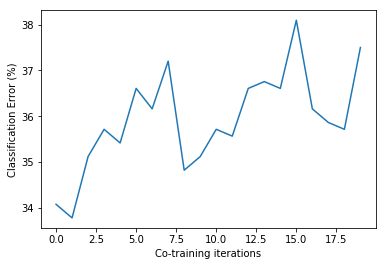

In [26]:
plt.figure()
plt.plot(100*np.array(errors))
plt.xlabel("Co-training iterations")
plt.ylabel("Classification Error (%)")
plt.savefig("Error Decrease 4.png")
plt.show()


### Using Diabetes Dataset

In [3]:
full_data = pd.read_csv("Diabetes_Dataset.csv")
full_labels = full_data['1']
full_data.head()
full_data = full_data.drop('1',1)

,6,148,72,35,0,33.6,0.627,50,1
0,1,85,66,29,0,26.6,0.351,31,0
1,8,183,64,0,0,23.3,0.672,32,1
2,1,89,66,23,94,28.1,0.167,21,0
3,0,137,40,35,168,43.1,2.288,33,1
4,5,116,74,0,0,25.6,0.201,30,0


In [5]:
full_data.head()

,6,148,72,35,0,33.6,0.627,50
0,1,85,66,29,0,26.6,0.351,31
1,8,183,64,0,0,23.3,0.672,32
2,1,89,66,23,94,28.1,0.167,21
3,0,137,40,35,168,43.1,2.288,33
4,5,116,74,0,0,25.6,0.201,30


In [9]:
X = full_data.as_matrix()
Y = full_labels.as_matrix()

In [14]:
print(X.shape)

(767, 8)


In [164]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=2)

In [165]:
# Split into two groups ("views")
Lsize = 20
X_train_L = X_train[:Lsize,:]
X_train_U = X_train[Lsize:,:]
y_train_L = y_train[:Lsize]
y_train_U = np.zeros_like(y_train[Lsize:])

In [166]:
print(X_train_L.shape)
print(X_train_U.shape)

(20, 8)
(670, 8)


In [167]:
from sklearn.naive_bayes import GaussianNB

# test fitting to a single view
gnb = GaussianNB()
gnb.fit(X_train_L, y_train_L)
probs = gnb.predict_proba(X_train_U)
y_pred = gnb.predict(X_train_U)
probs_class0 = probs[y_pred==0][:,0]
probs_class1 = probs[y_pred==1][:,1]
print("Accuracy iter 1 = ")
print(accuracy_score(y_test,gnb.predict(X_test)))
n = 30
new_labels = np.transpose(np.hstack([np.zeros(n,),np.ones(n,)]))
print(new_labels.shape)
topN_class0 = np.argsort(probs_class0)[-n:]
topN_class1 = np.argsort(probs_class1)[-n:]
top2N_class = np.transpose(np.hstack([topN_class0, topN_class1]))
print(top2N_class.shape)
# add these to the labeled set
# print(X_train_L.shape)
# print(X_train_U[topN_class0,:].shape)
# print(X_train_U[topN_class1,:].shape)
X_train_L = np.vstack([X_train_L,X_train_U[topN_class0,:],X_train_U[topN_class1,:]])

y_train_L = np.hstack([y_train_L,new_labels])

X_train_U = np.delete(X_train_U,top2N_class.T,0)
# print(X_train_U.shape)

# Iter 2

gnb.fit(X_train_L, y_train_L)
probs = gnb.predict_proba(X_train_U)
y_pred = gnb.predict(X_train_U)
probs_class0 = probs[y_pred==0][:,0]
probs_class1 = probs[y_pred==1][:,1]
print("Accuracy iter 2 = ")
print(accuracy_score(y_test,gnb.predict(X_test)))
n = 30
new_labels = np.transpose(np.hstack([np.zeros(n,),np.ones(n,)]))
print(new_labels.shape)
topN_class0 = np.argsort(probs_class0)[-n:]
topN_class1 = np.argsort(probs_class1)[-n:]
top2N_class = np.transpose(np.hstack([topN_class0, topN_class1]))
print(top2N_class.shape)
# add these to the labeled set
# print(X_train_L.shape)
# print(X_train_U[topN_class0,:].shape)
# print(X_train_U[topN_class1,:].shape)
X_train_L = np.vstack([X_train_L,X_train_U[topN_class0,:],X_train_U[topN_class1,:]])

y_train_L = np.hstack([y_train_L,new_labels])

X_train_U = np.delete(X_train_U,top2N_class.T,0)
print(X_train_U.shape)
print(X_train_L.shape)
print(y_train_L.shape)

# Iter 3

gnb.fit(X_train_L, y_train_L)
probs = gnb.predict_proba(X_train_U)
y_pred = gnb.predict(X_train_U)
probs_class0 = probs[y_pred==0][:,0]
probs_class1 = probs[y_pred==1][:,1]
print("Accuracy iter 3 = ")
print(accuracy_score(y_test,gnb.predict(X_test)))
n = 30
new_labels = np.transpose(np.hstack([np.zeros(n,),np.ones(n,)]))
print(new_labels.shape)
topN_class0 = np.argsort(probs_class0)[-n:]
topN_class1 = np.argsort(probs_class1)[-n:]
top2N_class = np.transpose(np.hstack([topN_class0, topN_class1]))
print(top2N_class.shape)
# add these to the labeled set
# print(X_train_L.shape)
# print(X_train_U[topN_class0,:].shape)
# print(X_train_U[topN_class1,:].shape)
X_train_L = np.vstack([X_train_L,X_train_U[topN_class0,:],X_train_U[topN_class1,:]])

y_train_L = np.hstack([y_train_L,new_labels])

X_train_U = np.delete(X_train_U,top2N_class.T,0)
print(X_train_U.shape)
print(X_train_L.shape)
print(y_train_L.shape)

# Iter 4

gnb.fit(X_train_L, y_train_L)
probs = gnb.predict_proba(X_train_U)
y_pred = gnb.predict(X_train_U)
probs_class0 = probs[y_pred==0][:,0]
probs_class1 = probs[y_pred==1][:,1]
print("Accuracy iter 4 = ")
print(accuracy_score(y_test,gnb.predict(X_test)))
n = 30
new_labels = np.transpose(np.hstack([np.zeros(n,),np.ones(n,)]))
print(new_labels.shape)
topN_class0 = np.argsort(probs_class0)[-n:]
topN_class1 = np.argsort(probs_class1)[-n:]
top2N_class = np.transpose(np.hstack([topN_class0, topN_class1]))
print(top2N_class.shape)
# add these to the labeled set
# print(X_train_L.shape)
# print(X_train_U[topN_class0,:].shape)
# print(X_train_U[topN_class1,:].shape)
X_train_L = np.vstack([X_train_L,X_train_U[topN_class0,:],X_train_U[topN_class1,:]])

y_train_L = np.hstack([y_train_L,new_labels])

X_train_U = np.delete(X_train_U,top2N_class.T,0)
print(X_train_U.shape)
print(X_train_L.shape)
print(y_train_L.shape)

# Iter 5

gnb.fit(X_train_L, y_train_L)
probs = gnb.predict_proba(X_train_U)
y_pred = gnb.predict(X_train_U)
probs_class0 = probs[y_pred==0][:,0]
probs_class1 = probs[y_pred==1][:,1]
print("Accuracy iter 5 = ")
print(accuracy_score(y_test,gnb.predict(X_test)))
n = 30
new_labels = np.transpose(np.hstack([np.zeros(n,),np.ones(n,)]))
print(new_labels.shape)
topN_class0 = np.argsort(probs_class0)[-n:]
topN_class1 = np.argsort(probs_class1)[-n:]
top2N_class = np.transpose(np.hstack([topN_class0, topN_class1]))
print(top2N_class.shape)
# add these to the labeled set
# print(X_train_L.shape)
# print(X_train_U[topN_class0,:].shape)
# print(X_train_U[topN_class1,:].shape)
X_train_L = np.vstack([X_train_L,X_train_U[topN_class0,:],X_train_U[topN_class1,:]])

y_train_L = np.hstack([y_train_L,new_labels])

X_train_U = np.delete(X_train_U,top2N_class.T,0)
print(X_train_U.shape)
print(X_train_L.shape)
print(y_train_L.shape)

Accuracy iter 1 = 
0.675324675325
(60,)
(60,)
Accuracy iter 2 = 
0.701298701299
(60,)
(60,)
(553, 8)
(140, 8)
(140,)
Accuracy iter 3 = 
0.753246753247
(60,)
(60,)
(496, 8)
(200, 8)
(200,)
Accuracy iter 4 = 
0.727272727273
(60,)
(60,)
(441, 8)
(260, 8)
(260,)
Accuracy iter 5 = 
0.701298701299
(60,)
(60,)
(383, 8)
(320, 8)
(320,)


In [ ]:
from sklearn.naive_bayes import GaussianNB
class CoTrainSingleView:
    def __init__(self):
        gnb1 = GaussianNB()
        
    def fit_full(self,X_L,y_L,X_U):
        # fit on the labeled data
        gnb1.fit(X_L,y_L)
        
    
        
        
        